# Basic tutorial: Interpolating bands, Berry curvatures, and integrating them

In this tutorial we will see how to compute band energies, Berry curvature, spins and anomalous Hall conductivity  using WannierBerri code and further integrate them over the Brillouin zone to obtain Anomalous Hall conductivity, and other quantities of interest.

## Preparation of a calculation:

* import the needed modules

* initialize a [Parallel() or Serial()](https://wannier-berri.org/docs/parallel.html) class 


In [1]:
# Preliminary 
# Set environment variables - not mandatory but recommended if you use parallel with maximum number of CPUs
#import os
#os.environ['OPENBLAS_NUM_THREADS'] = '1' 
#os.environ['MKL_NUM_THREADS'] = '1'

import ray
ray.init(num_cpus=8)

2025-11-20 05:16:31,151	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-20 05:16:34,354	INFO worker.py:1918 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.12.12
Ray version:,2.48.0
Dashboard:,http://127.0.0.1:8265


In [2]:

import wannierberri as wberri
print (f"Using WannierBerri version {wberri.__version__}")
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline



Using WannierBerri version 1.6.1


## Reading the system

Now we need to define the system that we are working on. Wannierberri can equally work with Wannier functions obtained by Wannier90 or other code (e.g. ASE or FPLO), as well as tight-binding models. This is done by constructing a [System()](https://wannier-berri.org/docs/system.html) class or one of its subclasses. Below, an example for Wannier90 is given; in advanced tutorials, some tight-binding models are also used.

In [3]:
# Importing data from wannier90
system=wberri.System_w90(
                        seedname='w90_files/Fe',
                        berry=True,   # needed to calculate "external terms" of Berry connection or curvature , reads ".mmn" file
                        spin = True , # needed for spin properties, reads ".spn" file
                        )


# Setting the pointgroup from the symmetry operations
import irrep
spacegroup = irrep.spacegroup.SpaceGroup.from_cell( real_lattice=system.real_lattice,
                                                   positions=[[0,0,0]],   # only 1 Fe atoms at origin
                                                   typat=[1],    # atomic number is not important here
                                                   spinor=True,
                                                   magmom=[[0,0,1]],   # magnetic moment along z
                                                   include_TR=True,   # include symmetries that flip the spin
                                                )
                                         
system.set_pointgroup(spacegroup=spacegroup)

# generators=["Inversion","C4z","TimeReversal*C2x"]
# system.set_pointgroup(symmetry_gen=generators)



Reading restart information from file w90_files/Fe.chk :
Time to read .chk : 0.014049530029296875
----------
 SPN  
---------

reading w90_files/Fe.spn : Created on  7May2022 at 16: 2:47                            
----------
 SPN OK  
---------

setting Rvec
setting AA..
setting AA - OK
Real-space lattice:
 [[ 1.4349963  1.4349963  1.4349963]
 [-1.4349963  1.4349963  1.4349963]
 [-1.4349963 -1.4349963  1.4349963]]
Number of wannier functions: 18
Number of R points: 113
Recommended size of FFT grid [4 4 4]


## Interpolation on a path

In [4]:
# Evaluate bands, Berry curvature, and spin along a path GHPNG


# all kpoints given in reduced coordinates
path=wberri.Path(system,
                 nodes=[
        [0.0000, 0.0000, 0.0000 ],   #  G 
        [0.500 ,-0.5000, -0.5000],   #  H 
        [0.7500, 0.2500, -0.2500],   #  P 
        [0.5000, 0.0000, -0.5000],   #  N 
        [0.0000, 0.0000, 0.000  ] ] , #  G 
                 labels=["G","H","P","N","G"],
                 length=200 )   # length [ Ang] ~= 2*pi/dk

# uncomment some of these lines to see what path you have generated

#print (path)

#print (path.getKline())

#for K in path.get_K_list():
#    print (K)

#print (np.array([K.K for K in path.get_K_list()]))



## Running a calculation: calculators and results

The calculation is called using the function [`run()`](https://wannier-berri.org/docs/run.html) : 

```
result=wberri.run(system, 
                  grid=path, 
                  calculators = {"key" : calculator},
                  parallel = parallel, 
                  print_Kpoints = False)
```
Here, apart from the already known ingredients, we need to define objects of some subclass of [`Calculator`](https://wannier-berri.org/docs/calculators.html#wannierberri.calculators.Calculator). A Calculator is a  callable object which returns some [`Result`](https://wannier-berri.org/docs/result.html). If you code another calculator, you can calculate other things using the machinery of WannierBerri, but that is not a part of this basic tutorial. 

Further, results are packed into [`ResultDict`](https://wannier-berri.org/docs/result.html#wannierberri.result.ResultDict) and returned. 


## Tabulating Berry curvature and spin

To run a tabulation one needs to compose a dictionary, where keys are any arbitrary strings to label further tabulation results, and the values are subclasses of [`Tabulator`](https://wannier-berri.org/docs/calculators.html#wannierberri.calculators.tabulate.Tabulator)

Next, we pack them into another class called [`TabulatorAll`](https://wannier-berri.org/docs/calculators.html#wannierberri.calculators.TabulatorAll), which represents a complex [`Calculator`](https://wannier-berri.org/docs/calculators.html#wannierberri.calculators.Calculator)

In [5]:

tabulators = { "energy": wberri.calculators.tabulate.Energy(),
               "berry_curvature" : wberri.calculators.tabulate.BerryCurvature(),
               "spin" : wberri.calculators.tabulate.Spin(),
             }

tab_all_path = wberri.calculators.TabulatorAll(
                    tabulators,
                    ibands = np.arange(0,18),
                    mode = "path"
                        )

### Running a calculation

Now run the calculation using the function [`run()`](https://wannier-berri.org/docs/run.html) . This will return an object of class [`ResultDict()`](https://wannier-berri.org/docs/result.html#wannierberri.result.ResultDict)
This object contains all results of the calculations, but in this case we have only one, which is marked `"tabulate"`


In [6]:
result=wberri.run(system, 
                  grid=path, 
                  calculators = {"tabulate" : tab_all_path},
                  print_Kpoints = False)

print (result.results)
path_result = result.results["tabulate"]


Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x7890a6f3fec0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "energy" : <wannierberri.calculators.tabulate.Energy object at 0x7890a6f1d610> : calculator not described

 "berry_curvature" : <wannierberri.calculators.tabulate.BerryCurvature object at 0x7890a6f1dca0> : calculator not described

 "spin" : <wannierberri.calculators.tabulate.Spin object at 0x7893d6cb0ec0> :  Spin expectation :math:` \langle u | \mathbf{\sigma} | u \rangle`

 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x7890a6de7cb0> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - check

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/grid/path.py:165: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing    215 K-points on   8 processes:     2.1204 ; per K-point          0.0099 ; proc-sec per K-point          0.0789
time1 =  0.03000020980834961
Totally processed 215 K-points 
run() finished
{'tabulate': <wannierberri.result.tabresult.TABresult object at 0x7890a6d481d0>}


### Alternative shortcut:

In [7]:
path , path_result= wberri.evaluate_k_path(system=system, 
                                            nodes=[
        [0.0000, 0.0000, 0.0000 ],   #  G 
        [0.500 ,-0.5000, -0.5000],   #  H 
        [0.7500, 0.2500, -0.2500],   #  P 
        [0.5000, 0.0000, -0.5000],   #  N 
        [0.0000, 0.0000, 0.000  ] ] , #  G 
                 labels=["G","H","P","N","G"],
                 length=200 ,
                quantities=["berry_curvature","spin"])

Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x7890a41f02c0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "berry_curvature" : <wannierberri.calculators.tabulate.BerryCurvature object at 0x7890a83c3890> : calculator not described

 "spin" : <wannierberri.calculators.tabulate.Spin object at 0x7890a83c3a40> :  Spin expectation :math:` \langle u | \mathbf{\sigma} | u \rangle`

 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x7890a41f0ef0> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x7890a

### Plotting the results

The [`TABresult`](https://wannier-berri.org/docs/result.html#wannierberri.result.TABresult) object already provides methods to plot the results. (As well as one can extract the data and plot them by other means). Below let's plot the interpolated bands and compare with those obtained in QE. (file "bands/Fe_bands_pw.dat" is already provided)


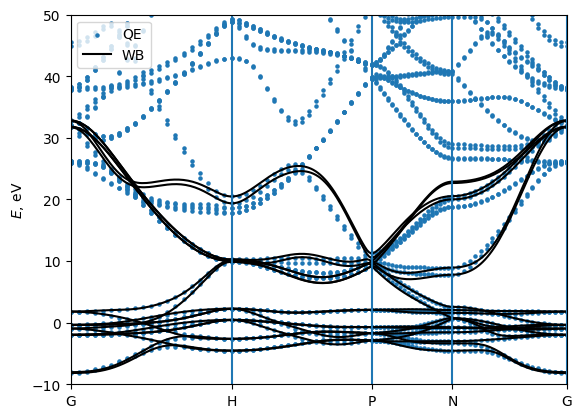

In [8]:
# plot the bands and compare with QuantumEspresso
EF = 12.6
# Import the pre-computed bands from quantum espresso
A = np.loadtxt(open("bands/Fe_bands_pw.dat","r"))
bohr_ang = scipy.constants.physical_constants['Bohr radius'][0] / 1e-10
alatt = 5.4235* bohr_ang
A[:,0]*= 2*np.pi/alatt
A[:,1]-=EF
# plot it as dots
plt.scatter (A[:,0],A[:,1],s=5,label = "QE")


path_result.plot_path_fat( path,
              quantity=None,
              save_file="Fe_bands+QE.pdf",
              Eshift=EF,
              Emin=-10,  Emax=50,
              iband=None,
              mode="fatband",
              fatfactor=20,
              cut_k=False, 
              close_fig=False,
              show_fig=False,
              label = "WB"
              )


plt.legend()
plt.show()
plt.close()


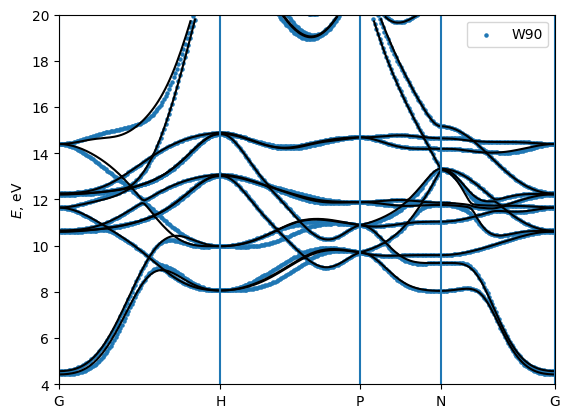

In [9]:
# plot the bands and compare with wannier90
A = np.loadtxt(open("bands/Fe_bands_w90.dat","r"))
plt.scatter (A[:,0],A[:,1],s=5,label = "W90")

path_result.plot_path_fat( path,
              quantity=None,
              save_file="Fe_bands+w90.pdf",
              Eshift=0,
              Emin=4,  Emax=20,
              iband=None,
              mode="fatband",
              fatfactor=20,
              cut_k=False, 
              close_fig=False,
              show_fig=False,
              label = "WB"
              )

plt.legend()

plt.show()
plt.close()

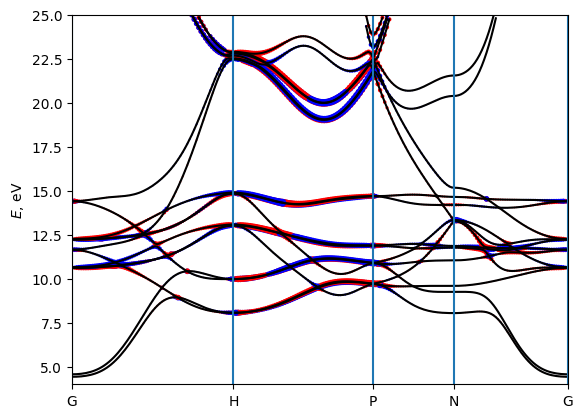

In [10]:
# plot the Berry curvature
path_result.plot_path_fat( path,
              quantity='berry_curvature',
              component='z',
              save_file=None, #"Fe_bands+berry.pdf",
              Eshift=0,
              Emin=4,  Emax=25,
              iband=None,
              mode="fatband",
              fatfactor=4,
              cut_k=False, 
              close_fig=False,
              show_fig=False,
              )
plt.show()
plt.close()

# The size of the dots corresponds to the magnitude of BC on a logarithmic scale

### Problem 1:

* modify the path
* plot the "z" component of spin along it (without . 
* do **not** plot QE or W90 bands in this case

Hint : look here for a proper Calculator https://wannier-berri.org/docs/calculators.html#tabulating


In [ ]:
# put the necessary code here






### Get the data and do whatever you want

In [11]:
k=path.getKline()
E=path_result.get_data(quantity='Energy',iband=(10,11))
curv=path_result.get_data(quantity='berry_curvature',iband=(10,11),component="z")
print (k.shape, E.shape, curv.shape)

(215,) (215, 2) (215, 2)


## Calaculation on a 3D grid

Now let's investigate how Berry curvature behaves in the 3D  Brillouin zone. For that we need to set a grid, which can be done in several ways, see input parameters [here](file:///home/stepan/github/wannier-berri-org/html/docs/grid.html)

Most important to recall, is that in WB one sets two grids : the FFT grid and the K-grid (NKdiv). this is important for running the calculation. However, the final; result depends only on their product. 

In [12]:
# Set a grid 
grid = wberri.Grid(system, length=50 )   # length [ Ang] ~= 2*pi/dk
#grid = wberri.Grid(system, NK=[24,24,24], NKFFT=4)
#grid = wberri.Grid(system, NKdiv=6, NKFFT=4)





Minimal symmetric FFT grid :  [4 4 4]


### We can use the same tabulators, but now we pack them into TabulatorAll in "grid" mode

In [13]:
tabulators = { "Energy": wberri.calculators.tabulate.Energy(),
               "berry_curvature" : wberri.calculators.tabulate.BerryCurvature(),
             }

tab_all_grid = wberri.calculators.TabulatorAll(
                    tabulators,
                    ibands = np.arange(0,18),
                    mode = "grid"
                        )

### And we run the calculation in the same way

In [14]:
result=wberri.run(system, 
                  grid=grid, 
                  calculators = {"tabulate" : tab_all_grid},
                  print_Kpoints = True)

print (result.results)
grid_result = result.results["tabulate"]

Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x789088618dd0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x789090153560> : calculator not described

 "berry_curvature" : <wannierberri.calculators.tabulate.BerryCurvature object at 0x7890886dfad0> : calculator not described

--------------------------------------------------

############################################################
Calculation on  grid - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x789088618dd0>
All calculators are compatible
Grid is regular
The set of k points is a Grid() with NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
generating

### Writing the FermiSurfer files

You may see that conversion to text format takes time. so convert only those components that you really need for plotting.

In [15]:
grid_result.write_frmsf(name="Fe_grid", quantity="berry_curvature",
                        components="z",
                        )

Enk (25, 25, 25, 18)
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 32 processes to write txt frmsf of 489 points per process
using a pool of 3

(16.544941186904907, 0.01615738868713379)

In [16]:
# Now we got some .frmsf files
!ls -al *.frmsf
# !rm *.frmsf

-rw-rw-r-- 1 stepan stepan 6592280 Nov 20 05:17 Fe_grid_berry_curvature-z.frmsf


In [ ]:
# let's look at them using the Fermisurfer! (https://fermisurfer.osdn.jp/)
!fermisurfer Fe_grid_berry_curvature-z.frmsf

### Analyze the tabulated data

In [17]:
# You may get the data as numpy arrays via:
Energy = grid_result.get_data(iband=5, quantity='Energy')
ahc  = grid_result.get_data(iband=5, quantity='berry_curvature',component='z')
print(ahc.shape,Energy.shape)

(25, 25, 25) (25, 25, 25)


### Problem 2 : 

### fill the missing parts and evaluate the Berry curvature summed over all states below EF = 12.6 eV. Plot in on a plane k3=const (in reduced coordinates)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.647687113016109..51.15952635204786].


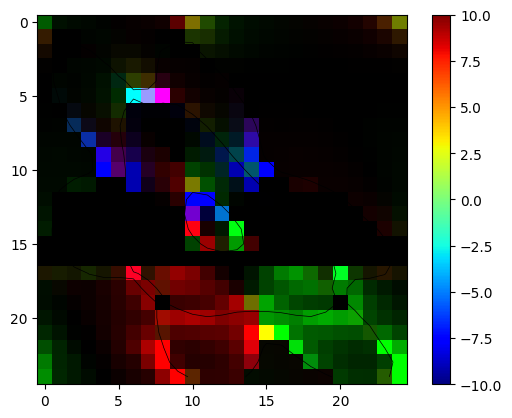

In [18]:
# example : find the total Berry curvature of occupied states
# on the plane (k1,k2), k3=const (in reduced coordinates)
Berry_occ = 0
k3 = 9
EF=12.4
for ib in range(18):
    Energy = grid_result.get_data(iband=ib, quantity='Energy')[:,:,k3]
    ahc  = grid_result.get_data(iband=ib, quantity='berry_curvature')[:,:,k3]
    ahc [Energy>EF] = 0
    Berry_occ += ahc
    plt.contour(Energy,levels = [EF],linewidths=0.5,colors='black')
shw = plt.imshow(Berry_occ,vmin=-10,vmax=10,cmap="jet")
bar = plt.colorbar(shw)

## Integration on a grid: anomalous Hall conductivity

Now, after we saw that the Berry curvature changes rapidly in the k-space, we understand that to get the precise value of AHC (\ref{eq:ahc}) defined as a Fermi-sea integral of Berry curvature

\begin{equation}
\sigma^{\rm AHC}_{xy} = -\frac{e^2}{\hbar} \sum_n^{\rm occ} \int\frac{d\mathbf{k}}{(2\pi)^3} \Omega^n_\gamma
\label{eq:ahc}\tag{1}
\end{equation}

we need a very dense grid. The calculation is done again, by using the calculators. AHC may be viewed as a function of the Fermi level. Such calculators are called [StaticCalculator](https://wannier-berri.org/docs/calculators.html#static-dependent-only-on-fermi-level) , because the corresponding effects can be measured in static fields. (as opposed to dynamic calculators, see below).

In [19]:
calculators = {}
Efermi = np.linspace(12,13,101)
omega = np.linspace(0,1.,101)
# Set a grid 
grid = wberri.Grid(system, length=50 )   # length [ Ang] ~= 2*pi/dk

calculators ["ahc"] = wberri.calculators.static.AHC(Efermi=Efermi)

result_run = wberri.run(system,
            grid=grid,
            calculators = calculators,
            adpt_num_iter=5,
            fout_name='Fe',
            restart=False,
            file_Klist="Klist_ahc.pickle"  # needed to restart a calculation in future
            )



Minimal symmetric FFT grid :  [4 4 4]
Starting run()
Using the follwing calculators : 
############################################################

 'ahc'  :  <wannierberri.calculators.static.AHC object at 0x7890a409d430>  : Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta = \epsilon_{\alpha\beta\delta} O_\delta E_\beta`
############################################################
Calculation on  grid - checking calculators for compatibility
ahc <wannierberri.calculators.static.AHC object at 0x7890a409d430>
All calculators are compatible
Grid is regular
The set of k points is a Grid() with NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
generating K_list
Done in 0.001283884048461914 s 
excluding symmetry-equivalent K-points from

In [ ]:
!ls

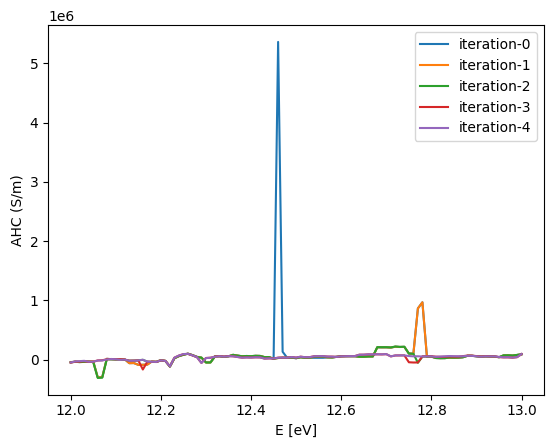

In [20]:
#plot results from different iterations
#plot results from different iterations
for i in range(5):
    res = np.load(f"Fe-ahc_iter-{i:04d}.npz")
    # print (list(res.keys()))
    ef = res["Energies_0"]
    ahc_xy = res["data"][:,2]
    # alternatively from text files:
    # a = np.loadtxt(f"Fe-ahc_iter-{i:04d}.dat")
    # ef = a[:,0] 
    # ahc_xy = a[:,3]
    plt.plot(ef,ahc_xy,label = f"iteration-{i}")
#plt.ylim(-1000,1000)
plt.xlabel("E [eV]")
plt.ylabel("AHC (S/m)")
plt.legend()
plt.show()

In [21]:
result_run = wberri.run(system,
            grid=grid,
            calculators = calculators,
            adpt_num_iter=10,
            fout_name='Fe',
            restart=True,
            file_Klist="Klist_ahc.pickle"  # needed to restart a calculation
            )

Starting run()
Using the follwing calculators : 
############################################################

 'ahc'  :  <wannierberri.calculators.static.AHC object at 0x7890a409d430>  : Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta = \epsilon_{\alpha\beta\delta} O_\delta E_\beta`
############################################################
Calculation on  grid - checking calculators for compatibility
ahc <wannierberri.calculators.static.AHC object at 0x7890a409d430>
All calculators are compatible
Grid is regular
The set of k points is a Grid() with NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
Finished reading Klist from file Klist_ahc.pickle
54 K-points were read from Klist_ahc.pickle
9 K-points were read from Klist_ahc.c

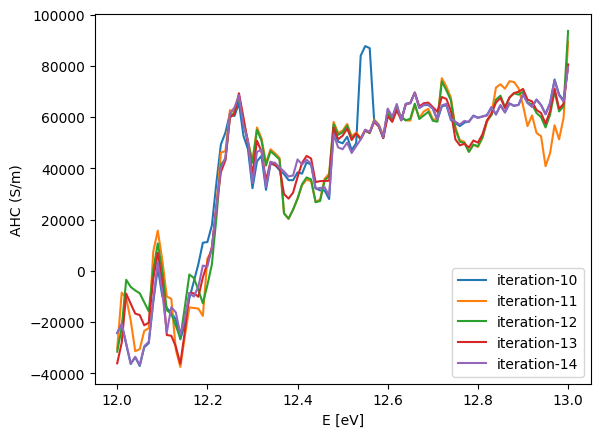

In [22]:
#plot results from different iterations
for i in range(10,15):
    res = np.load(f"Fe-ahc_iter-{i:04d}.npz")
    # print (list(res.keys()))
    ef = res["Energies_0"]
    ahc_xy = res["data"][:,2]
    # alternatively from text files:
    # a = np.loadtxt(f"Fe-ahc_iter-{i:04d}.dat")
    # ef = a[:,0] 
    # ahc_xy = a[:,3]
    plt.plot(ef,ahc_xy,label = f"iteration-{i}")
#plt.ylim(-1000,1000)
plt.xlabel("E [eV]")
plt.ylabel("AHC (S/m)")
plt.legend()
plt.show()

### Problem 3 : 
start from a denser grid (length=100 or 200) and do the integration again with 20 iterations. Plot the results

In [ ]:
# insert the needed code below




## Tetrahedron method

Minimal symmetric FFT grid :  [4 4 4]
Starting run()
Using the follwing calculators : 
############################################################

 'dos_notetra'  :  <wannierberri.calculators.static.DOS object at 0x78908857d7f0>  : Density of states
 'dos_tetra'  :  <wannierberri.calculators.static.DOS object at 0x78908857ed20>  : Density of states
############################################################
Calculation on  grid - checking calculators for compatibility
dos_notetra <wannierberri.calculators.static.DOS object at 0x78908857d7f0>
dos_tetra <wannierberri.calculators.static.DOS object at 0x78908857ed20>
All calculators are compatible
Grid is regular
The set of k points is a Grid() with NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
generating K_list
Done in 0.0017361640930175781 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.010408401489257812 s 
K_list contains 18 Irreducible points(14.4%) out of initial 5x5x5=125 grid
Done, sum of weights:1.0000000

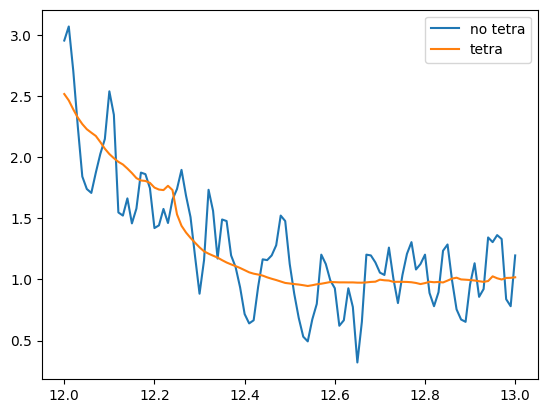

In [23]:
calculators = {}
Efermi = np.linspace(12,13,101)
omega = np.linspace(0,1.,101)
# Set a grid 
grid = wberri.Grid(system, length=50 )   # length [ Ang] ~= 2*pi/dk

calculators ["dos_notetra"] = wberri.calculators.static.DOS(Efermi=Efermi,tetra=False)
calculators ["dos_tetra"] = wberri.calculators.static.DOS(Efermi=Efermi,tetra=True)

result_run = wberri.run(system,
            grid=grid,
            calculators = calculators,
            adpt_num_iter=0,
            fout_name='Fe',
            suffix = "run2",
            restart=False,
            print_Kpoints=False
            )

a = np.loadtxt(f"Fe-dos_notetra-run2_iter-0000.dat")
plt.plot(a[:,0],a[:,1],label = f"no tetra")
a = np.loadtxt(f"Fe-dos_tetra-run2_iter-0000.dat")
plt.plot(a[:,0],a[:,1],label = f"tetra")
plt.legend()

In [ ]:
!ls


## Optical conductivity

In [24]:
calculators = {}
Efermi = np.linspace(12,13,101)
omega = np.linspace(0,1.,101)
# Set a grid 
grid = wberri.Grid(system, length=50 )   # length [ Ang] ~= 2*pi/dk

calculators["opt_conductivity"] = wberri.calculators.dynamic.OpticalConductivity(
                            Efermi=Efermi,omega=omega)


result_run_opt = wberri.run(system,
            grid=grid,
            calculators = calculators,
            adpt_num_iter=0,
            fout_name='Fe',
            suffix = "run3",
            restart=False,
            )

Minimal symmetric FFT grid :  [4 4 4]
Starting run()
Using the follwing calculators : 
############################################################

 'opt_conductivity'  :  <wannierberri.calculators.dynamic.OpticalConductivity object at 0x7890881efec0>  : calculator not described
############################################################
Calculation on  grid - checking calculators for compatibility
opt_conductivity <wannierberri.calculators.dynamic.OpticalConductivity object at 0x7890881efec0>
All calculators are compatible
Grid is regular
The set of k points is a Grid() with NKdiv=[5 5 5], NKFFT=[5 5 5], NKtot=[25 25 25]
generating K_list
Done in 0.0007431507110595703 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.009906768798828125 s 
K_list contains 18 Irreducible points(14.4%) out of initial 5x5x5=125 grid
Done, sum of weights:1.0000000000000004

############################################################
Iteration 0 out of 0 
processing 18 K points : usin

(101, 101, 3, 3)
[12.   12.01 12.02 12.03 12.04 12.05 12.06 12.07 12.08 12.09 12.1  12.11
 12.12 12.13 12.14 12.15 12.16 12.17 12.18 12.19 12.2  12.21 12.22 12.23
 12.24 12.25 12.26 12.27 12.28 12.29 12.3  12.31 12.32 12.33 12.34 12.35
 12.36 12.37 12.38 12.39 12.4  12.41 12.42 12.43 12.44 12.45 12.46 12.47
 12.48 12.49 12.5  12.51 12.52 12.53 12.54 12.55 12.56 12.57 12.58 12.59
 12.6  12.61 12.62 12.63 12.64 12.65 12.66 12.67 12.68 12.69 12.7  12.71
 12.72 12.73 12.74 12.75 12.76 12.77 12.78 12.79 12.8  12.81 12.82 12.83
 12.84 12.85 12.86 12.87 12.88 12.89 12.9  12.91 12.92 12.93 12.94 12.95
 12.96 12.97 12.98 12.99 13.  ]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0

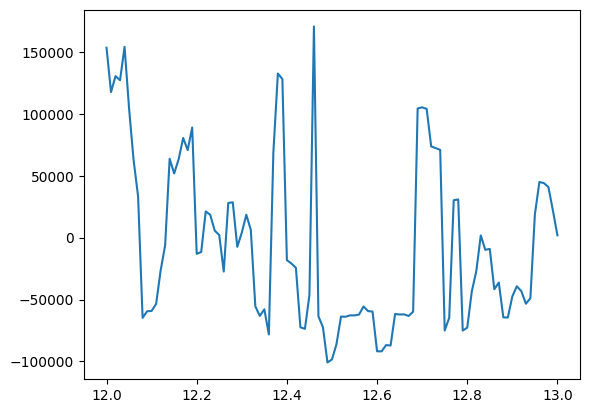

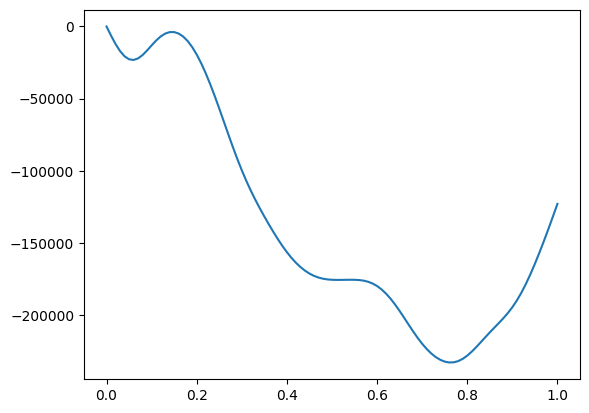

In [25]:
#plot results from new iterations
res = result_run_opt.results["opt_conductivity"]
print (res.data.shape)
print (res.Energies[0]) # Efermi
print (res.Energies[1]) # omega

# plot at fixed omega
iw = 10
plt.plot(res.Energies[0], res.data[:,iw,2,2].imag)
plt.show()

# plot at fixed Efermi
ief = 20
plt.plot(res.Energies[1], res.data[ief,:,2,2].imag)
plt.show()


In [ ]:
!ls

## All in one

In [26]:
calculators = {}
Efermi = np.linspace(12,13,101)
omega = np.linspace(0,1.,101)
# Set a grid 
grid = wberri.Grid(system, length=50 )   # length [ Ang] ~= 2*pi/dk

calculators ["ahc_notetra"] = wberri.calculators.static.AHC(Efermi=Efermi,tetra=False)
calculators ["ahc_tetra"] = wberri.calculators.static.AHC(Efermi=Efermi,tetra=True)
calculators ["tabulate"] = wberri.calculators.TabulatorAll({
                            "Energy":wberri.calculators.tabulate.Energy(),
                            "berry":wberri.calculators.tabulate.BerryCurvature(),
                                  },   
                            ibands = np.arange(4,10))
calculators["opt_conductivity"] = wberri.calculators.dynamic.OpticalConductivity(
                            Efermi=Efermi,omega=omega)


result_run = wberri.run(system,
            grid=grid,
            calculators = calculators,
            adpt_num_iter=0,
            fout_name='Fe',
            suffix = "run",
            restart=False,
            )

Minimal symmetric FFT grid :  [4 4 4]
Starting run()
Using the follwing calculators : 
############################################################

 'ahc_notetra'  :  <wannierberri.calculators.static.AHC object at 0x78908857ed20>  : Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta = \epsilon_{\alpha\beta\delta} O_\delta E_\beta`
 'ahc_tetra'  :  <wannierberri.calculators.static.AHC object at 0x7890881ee210>  : Anomalous Hall conductivity (:math:`s^3 \cdot A^2 / (kg \cdot m^3) = S/m`)

        | With Fermi sea integral Eq(11) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`__
        | Output: :math:`O = -e^2/\hbar \int [dk] \Omega f`
        | Instruction: :math:`j_\alpha = \sigma_{\alpha\beta} E_\beta = \epsilon_{